<a href="https://colab.research.google.com/github/tcole333/data-centric-ai/blob/main/data_centric_ai_comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import requests
import tarfile
import io
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import pandas as pd
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import os
import tensorflow as tf
from tensorflow import keras
import json
import sys

In [59]:
#download the files from github and extract them and move the sample labels to a new folder called test
!wget https://github.com/tcole333/data-centric-ai/blob/main/data.tar.gz?raw=true
tar = tarfile.open('data.tar.gz?raw=true')
tar.extractall()
!wget https://github.com/tcole333/data-centric-ai/blob/main/label_book.tar.gz?raw=true
tar = tarfile.open('label_book.tar.gz?raw=true')
tar.extractall()
!mv "/content/label_book" "/content/data/test"


--2021-06-21 21:58:03--  https://github.com/tcole333/data-centric-ai/blob/main/data.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/tcole333/data-centric-ai/raw/main/data.tar.gz [following]
--2021-06-21 21:58:03--  https://github.com/tcole333/data-centric-ai/raw/main/data.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tcole333/data-centric-ai/main/data.tar.gz [following]
--2021-06-21 21:58:04--  https://raw.githubusercontent.com/tcole333/data-centric-ai/main/data.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting resp

(232, 232, 3)


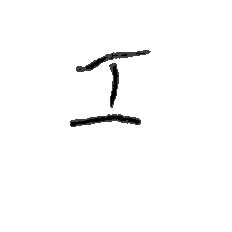

In [64]:
#read a file and convert to an array and back to an image
img = load_img('/content/data/train/i/ab9fb784-ce5d-11eb-b317-38f9d35ea60f.png')
img_numpy_array = img_to_array(img)
print(img_numpy_array.shape)
#print(img_numpy_array)
img_pil_from_numpy_array = array_to_img(img_numpy_array)
img_pil_from_numpy_array

In [61]:
directory = "/content/data"
user_data = directory + "/train"
valid_data = directory + "/val"
test_data = directory + "/test" # this can be the label book, or any other test set you create

### DO NOT MODIFY BELOW THIS LINE, THIS IS THE FIXED MODEL ###
batch_size = 8
tf.random.set_seed(123)


if __name__ == "__main__":
    train = tf.keras.preprocessing.image_dataset_from_directory(
        user_data,# + '/train',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
    )

    valid = tf.keras.preprocessing.image_dataset_from_directory(
        user_data,# + '/val',
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=True,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
    )

    total_length = ((train.cardinality() + valid.cardinality()) * batch_size).numpy()
    if total_length > 10_000:
        print(f"Dataset size larger than 10,000. Got {total_length} examples")
        sys.exit()

    test = tf.keras.preprocessing.image_dataset_from_directory(
        test_data,
        labels="inferred",
        label_mode="categorical",
        class_names=["i", "ii", "iii", "iv", "v", "vi", "vii", "viii", "ix", "x"],
        shuffle=False,
        seed=123,
        batch_size=batch_size,
        image_size=(32, 32),
    )

    base_model = tf.keras.applications.ResNet50(
        input_shape=(32, 32, 3),
        include_top=False,
        weights=None,
    )
    base_model = tf.keras.Model(
        base_model.inputs, outputs=[base_model.get_layer("conv2_block3_out").output]
    )

    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = tf.keras.applications.resnet.preprocess_input(inputs)
    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(10)(x)
    model = tf.keras.Model(inputs, x)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    model.summary()
    loss_0, acc_0 = model.evaluate(valid)
    print(f"loss {loss_0}, acc {acc_0}")

    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        "best_model",
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        train,
        validation_data=valid,
        epochs=100,
        callbacks=[checkpoint],
    )

    model.load_weights("best_model")

    loss, acc = model.evaluate(valid)
    print(f"final loss {loss}, final acc {acc}")

    test_loss, test_acc = model.evaluate(test)
    print(f"test loss {test_loss}, test acc {test_acc}")

   

Found 2067 files belonging to 10 classes.
Found 2067 files belonging to 10 classes.
Found 52 files belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 32, 32, 3)         0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 32, 32, 3)         0         
_________________________________________________________________
model (Functional)           (None, 8, 8, 256)         229760    
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 232,330
Trainable params: 229,386
Non-trainable params: 2,944
_________________________________________________

KeyboardInterrupt: ignored